In [3]:
import pandas as pd
from deap import base, creator, tools, algorithms
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv("../data/df_score.csv", index_col=[0])

In [48]:
df["Score_2"] = [np.random.randint(0,1000) for _ in range(df.shape[0])]

In [69]:
def taux_defaut(limites):
    df["Classes"] = np.digitize(df["Score_ind"], bins=limites)
    defaut = df.groupby("Classes")["TARGET"].mean()
    return defaut

def evalSegmentation1(individu):
    limites = sorted(individu)  
    taux = taux_defaut(limites)
    
    if len(taux) != 7 : 
        return(0, )
    if all(taux[i] <= taux[i+1] for i in range(1, len(taux)-1)):
        return len(set(np.digitize(df["Score_ind"], bins=limites))),
    else : 
        return 0,
    
def evalSegmentation(individu, seuil_minimum=7):
    limites = sorted(individu)
    taux = taux_defaut(limites)
    
    if len(taux)<7 : 
        penalites_seuil = 7 - len(taux)
        fitness = -(penalites_seuil * 100) 
    else : 
        diffs = [taux[i+1] - taux[i] for i in range(1, len(taux)-1)]
        penalites_diffs = sum(d < 0 for d in diffs)
        fitness = sum(d for d in diffs if d > 0) - (penalites_diffs * 100) 
    return fitness,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, min(df["Score_ind"]), max(df["Score_ind"])) 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.decorate("mate", checkBounds(min(df["Score_ind"]), max(df["Score_ind"])))
toolbox.decorate("mutate", checkBounds(min(df["Score_ind"]), max(df["Score_ind"])))

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalSegmentation)

population = toolbox.population(n=50)
CXPB, MUTPB, NGEN = 0.5, 0.2, 40

for gen in range(NGEN):
    print(f"Generation: {gen + 1}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

    best_ind = tools.selBest(population, 1)[0]
    print(f"  Meilleur individu: {sorted(best_ind)}, Fitness: {best_ind.fitness.values}")

best_ind = tools.selBest(population, 1)[0]
print("Meilleur individu est %s, %s" % (best_ind, best_ind.fitness.values))

Generation: 1
  Meilleur individu: [282.258064516129, 391.16793193689904, 470.1454720491761, 569.6479512680978, 646.2699853138931, 839.5374419427122], Fitness: (-100.0,)
Generation: 2
  Meilleur individu: [282.258064516129, 511.29510076958803, 515.9341645466097, 593.8185222647608, 751.8801662833594, 801.3932352681909], Fitness: (-100.0,)
Generation: 3
  Meilleur individu: [282.258064516129, 546.4389006773979, 552.5609694682423, 579.4819481015817, 746.6059753513906, 840.6170050102032], Fitness: (-100.0,)
Generation: 4
  Meilleur individu: [282.258064516129, 429.5999198569358, 522.9595423774244, 545.241910943506, 594.745644048201, 672.7660068255207], Fitness: (-100.0,)
Generation: 5
  Meilleur individu: [282.258064516129, 491.1155375295941, 504.28838822383545, 516.8504814960169, 629.4722452470862, 732.327109437473], Fitness: (-100.0,)
Generation: 6
  Meilleur individu: [282.258064516129, 481.9976199144504, 647.9910695369414, 716.8115765418875, 751.9392009034457, 774.9602879326195], Fitne

In [70]:
df["Classes"] = np.digitize(df["Score_2"], bins=sorted(best_ind))
defaut = df.groupby("Classes")["TARGET"].mean()

In [71]:
defaut

Classes
0    0.075688
1    0.076333
2    0.074388
3    0.079685
4    0.075819
5    0.075185
6    0.076029
Name: TARGET, dtype: float64

# JENkS

In [5]:
import jenkspy

scores_clients = df["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 184.8341232227488, 317.5355450236967, 421.8009478672986, 554.5023696682465, 720.3791469194314, 1000.0]


In [31]:
breaks = [0, 200, 317, 450, 500, 650, 780]

df["Classes"] = np.digitize(df["Score_ind"], bins=sorted(breaks))

resultats = df.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size")  
)
resultats['taux_individus'] = (resultats['nb_individus'] / df.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.138021         12230        4.367857
2              0.111102         35130       12.546429
3              0.086421         59974       21.419286
4              0.068234         83580       29.850000
5              0.055701         62010       22.146429
6              0.046864         19930        7.117857
7              0.041842          7146        2.552143


In [25]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [26]:
def plot_stability_taux(train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

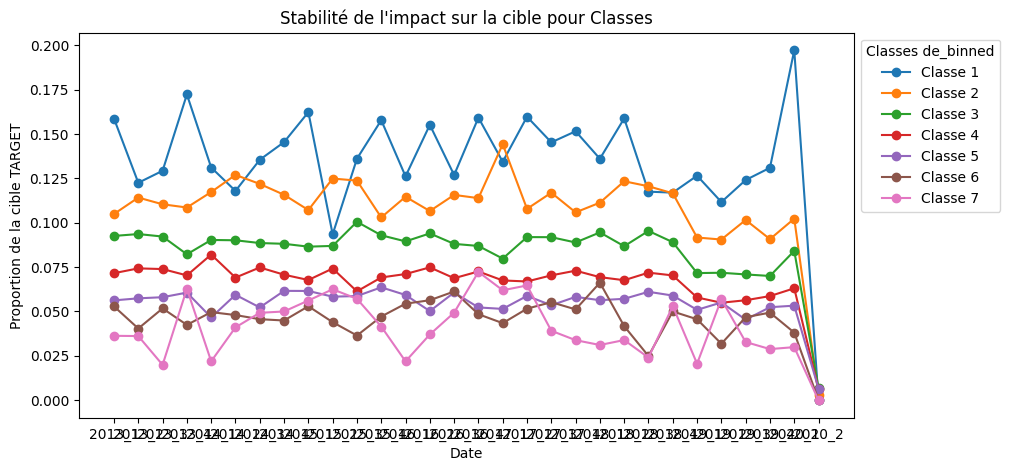

In [27]:
plot_stability_taux(df, "Classes")